# Углублённое моделирование модели, интерпретация через SHAP

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import ConfusionMatrixDisplay, PrecisionRecallDisplay, RocCurveDisplay
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import shap

#### Данные

In [ ]:
train_df = pd.read_csv('../data/train_preprocessed.csv')
test_df = pd.read_csv('../data/test_preprocessed.csv')

X_test = test_df.drop('Churn', axis=1)
y_test = test_df['Churn']

scaler = StandardScaler()

X_test_processed = scaler.fit_transform(X_test)
X_test_processed_df = pd.DataFrame(
    X_test_processed, 
    columns=X_test.columns.tolist(), 
    index=X_test.index
)

model = joblib.load('../model/trained_model.pkl')

y_pred = model.predict(X_test_processed)
y_proba = model.predict_proba(X_test_processed)

#### Confusion Matrix

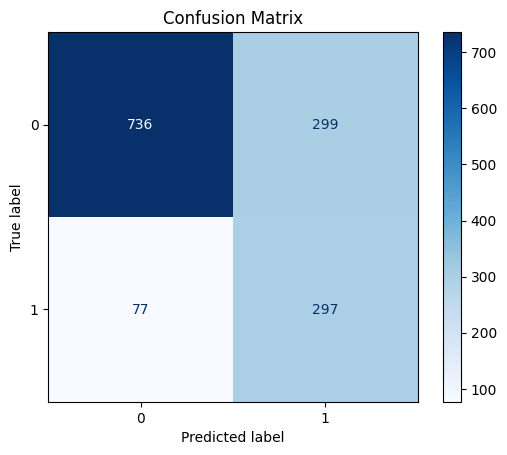

In [22]:
display = ConfusionMatrixDisplay.from_estimator(
    model,
    X_test_processed,
    y_test,
    cmap='Blues'
)

_ = display.ax_.set_title('Confusion Matrix')

#### Precision-Recall Curve

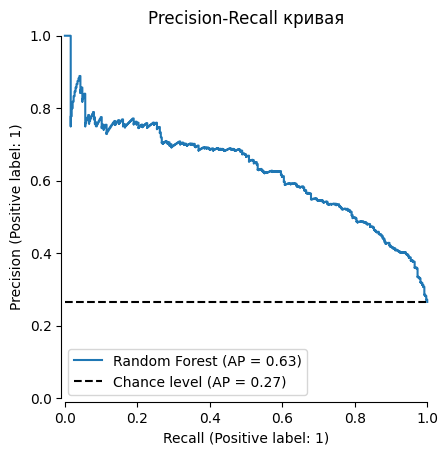

In [23]:
display = PrecisionRecallDisplay.from_estimator(
    model,
    X_test_processed,
    y_test,
    name='Random Forest',
    plot_chance_level=True, 
    despine=True
)

_ = display.ax_.set_title('Precision-Recall кривая')

#### ROC-AUC Curve

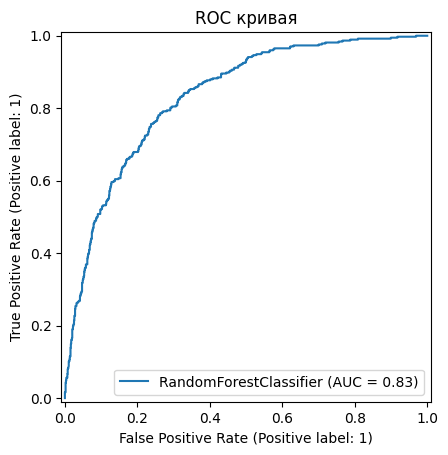

In [24]:
display = RocCurveDisplay.from_estimator(
    model,
    X_test_processed,
    y_test
)

_ = display.ax_.set_title('ROC кривая')

#### SHAP интерпретация

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values_simple = explainer.shap_values(X_test_processed_df)

if isinstance(shap_values_simple, list) and len(shap_values_simple) == 2:
    shap_values = shap_values_simple[1]
else:
    shap_values = shap_values_simple

Summary plot

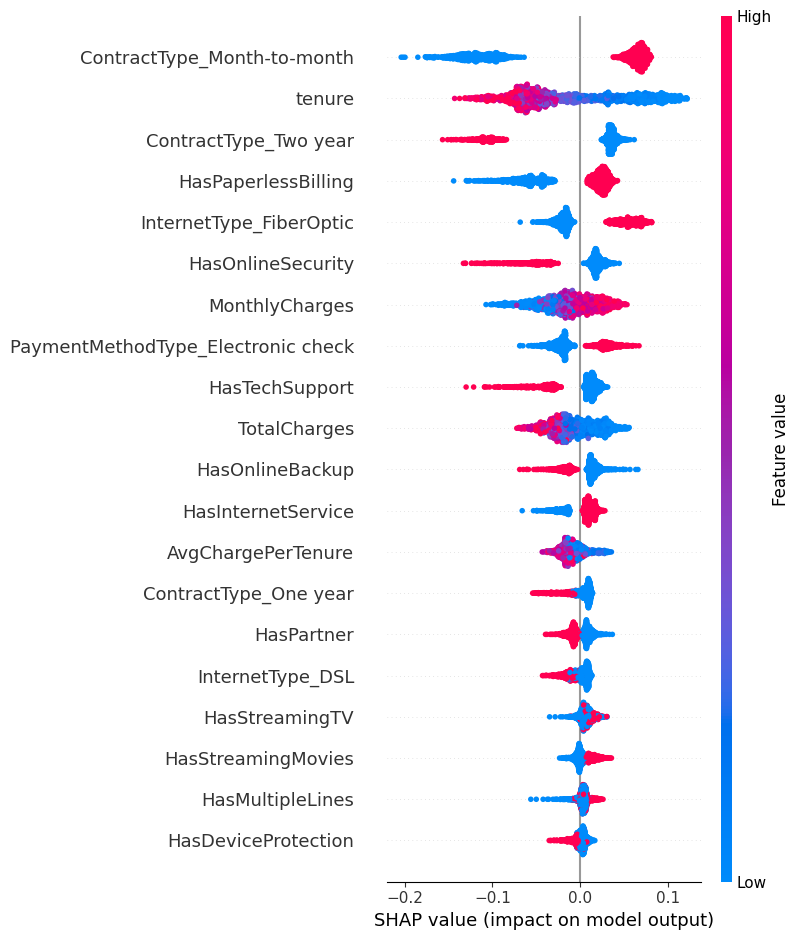

In [67]:
shap.summary_plot(shap_values[:, :, 1], X_test_processed_df)

Влияние параметров на уход

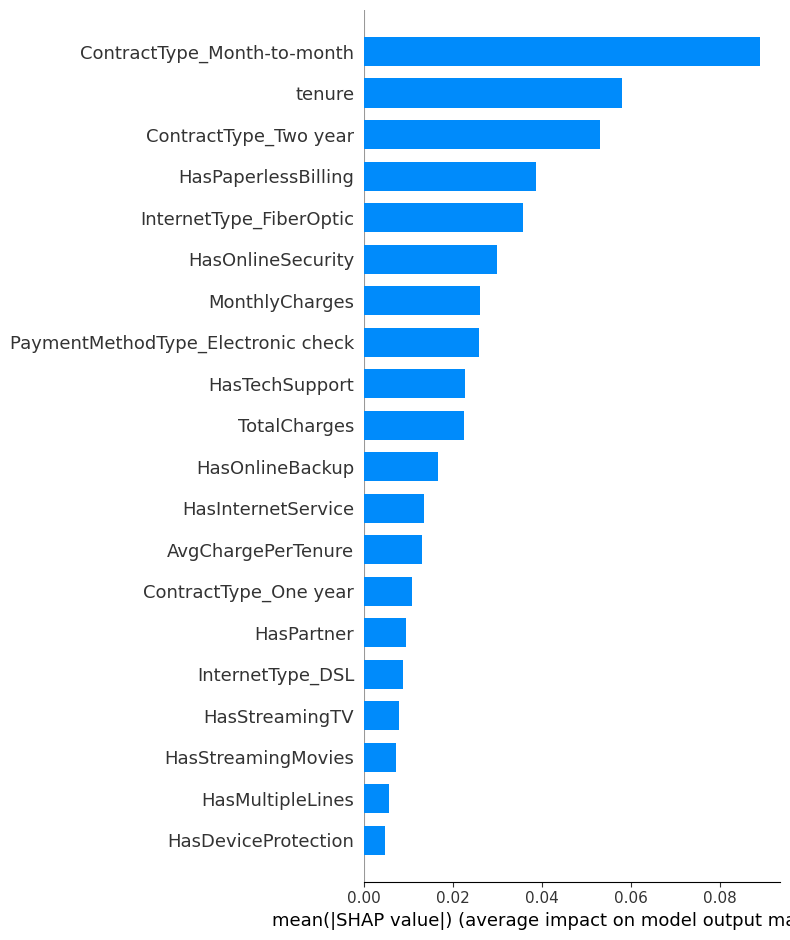

In [65]:
shap.summary_plot(shap_values[:, :, 1], X_test_processed_df, plot_type="bar")

c:\Users\илья\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Клиент №1
Вероятность ухода: 0.705
Фактический статус: 0

Данные клиента:
gender                                           0.00
SeniorCitizen                                    1.00
tenure                                           8.00
MonthlyCharges                                 100.15
TotalCharges                                   908.55
HasPartner                                       0.00
HasDependents                                    0.00
HasPhoneService                                  1.00
HasPaperlessBilling                              1.00
HasInternetService                               1.00
InternetType_DSL                                 0.00
InternetType_FiberOptic                          1.00
HasMultipleLines                                 1.00
HasOnlineSecurity                                0.00
HasOnlineBackup                                  0.00
HasDeviceProtection                              0.00
HasTechSupport                                   1.00
HasStrea

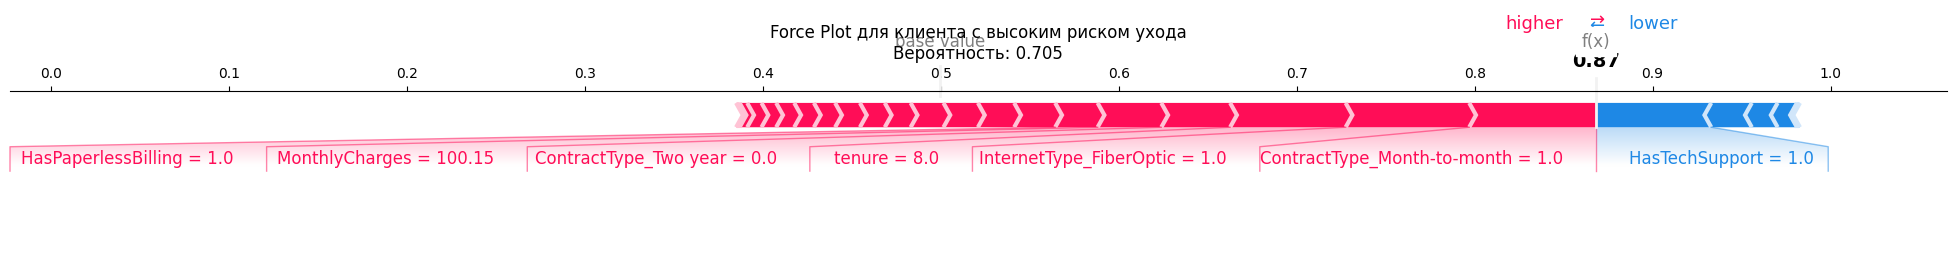

In [ ]:
base_value = explainer.expected_value
if isinstance(base_value, np.ndarray):
    base_value = base_value[1]
predictions = model.predict_proba(X_test)[:, 1]
high_risk_indices = np.where(predictions > 0.7)[0]

if len(high_risk_indices) > 0:
    client_idx = high_risk_indices[0]
    
    print(f"Клиент №{client_idx}")
    print(f"Вероятность ухода: {predictions[client_idx]:.3f}")
    print(f"Фактический статус: {y_test.iloc[client_idx]}")
    print("\nДанные клиента:")
    print(X_test.iloc[client_idx])
    
    shap.force_plot(
        base_value,
        shap_values[client_idx, :, 1],
        X_test.iloc[client_idx, :],
        matplotlib=True, 
        show=False
    )
    
    plt.title(f'Force Plot для клиента с высоким риском ухода\n'
              f'Вероятность: {predictions[client_idx]:.3f}')
    plt.tight_layout()
    plt.show()

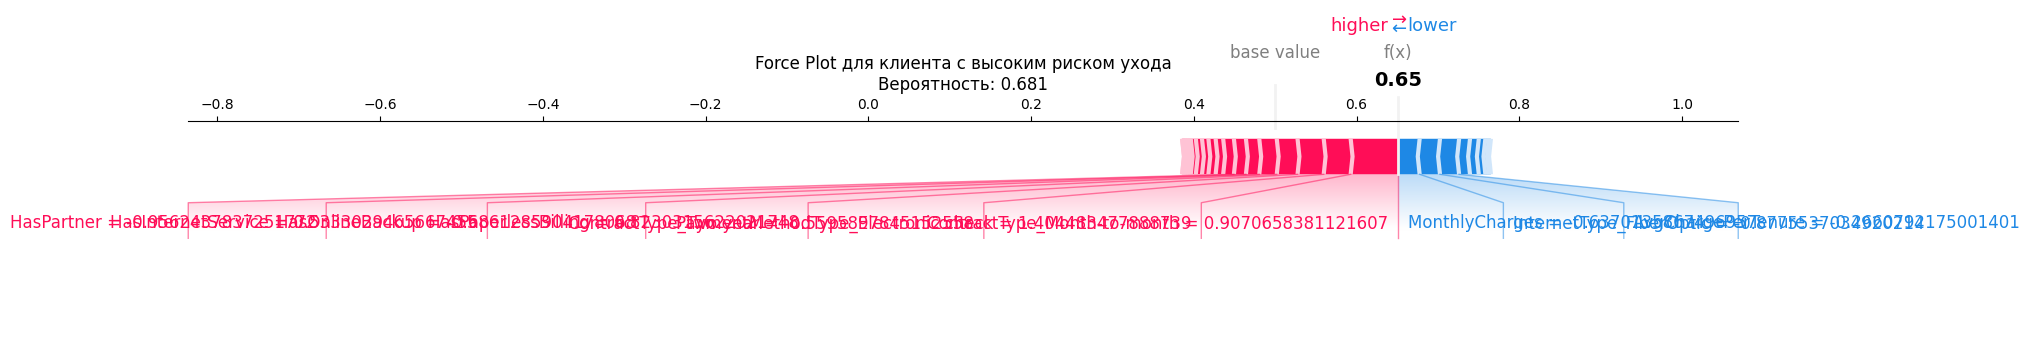

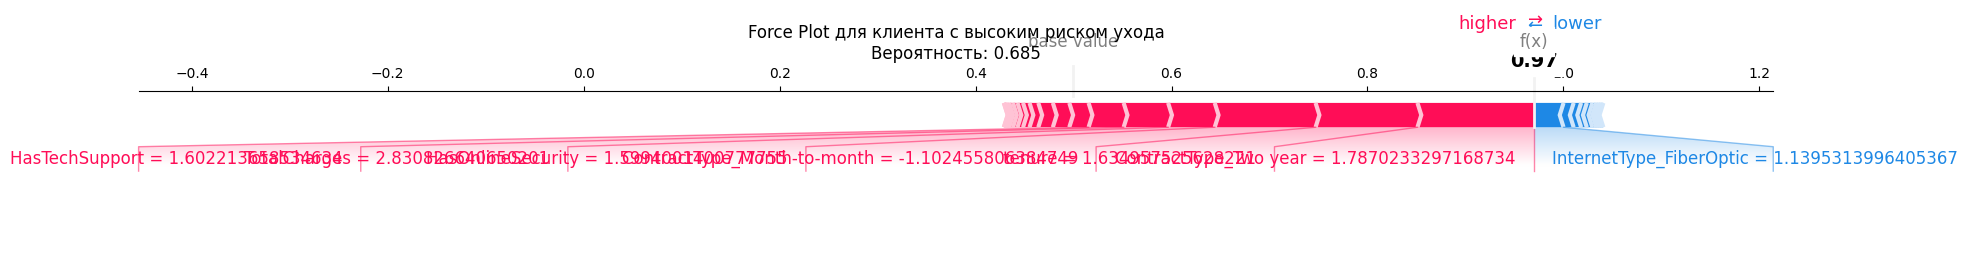

In [90]:
churned_indices = np.where(y_test == 1)[0]
loyal_indices = np.where(y_test == 0)[0]

if len(churned_indices) > 0 and len(loyal_indices) > 0:
    churned_client_idx = churned_indices[0]
    loyal_client_idx = loyal_indices[0]
    
    shap.force_plot(
        base_value,
        shap_values[churned_client_idx, :, 1],
        X_test_processed_df.iloc[churned_client_idx, :],
        matplotlib=True,
        show=False
    )
    plt.title(f'Force Plot для клиента с высоким риском ухода\n'
              f'Вероятность: {predictions[churned_client_idx]:.3f}')
    
    shap.force_plot(
        base_value,
        shap_values[loyal_client_idx, :, 0],
        X_test_processed_df.iloc[loyal_client_idx, :],
        matplotlib=True,
        show=False
    )
    plt.title(f'Force Plot для клиента с высоким риском ухода\n'
              f'Вероятность: {predictions[loyal_client_idx]:.3f}')
    
    plt.tight_layout()
    plt.show()

In [ ]:
feature_importance = np.abs(shap_values[:, :, 1]).mean(axis=0)
importance_df = pd.DataFrame({
    'feature': X_test_processed_df.columns,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("Важность признаков:")
print(importance_df)

top_features = importance_df.head(3)['feature'].tolist()
print(f"\nТоп-3 самых важных признаков: {top_features}")

Важность признаков:
                                        feature  importance
19                  ContractType_Month-to-month    0.089053
2                                        tenure    0.057932
21                        ContractType_Two year    0.052993
8                           HasPaperlessBilling    0.038668
11                      InternetType_FiberOptic    0.035777
13                            HasOnlineSecurity    0.030001
3                                MonthlyCharges    0.026062
24           PaymentMethodType_Electronic check    0.025867
16                               HasTechSupport    0.022763
4                                  TotalCharges    0.022543
14                              HasOnlineBackup    0.016598
9                            HasInternetService    0.013548
26                           AvgChargePerTenure    0.012990
20                        ContractType_One year    0.010722
5                                    HasPartner    0.009382
10                  

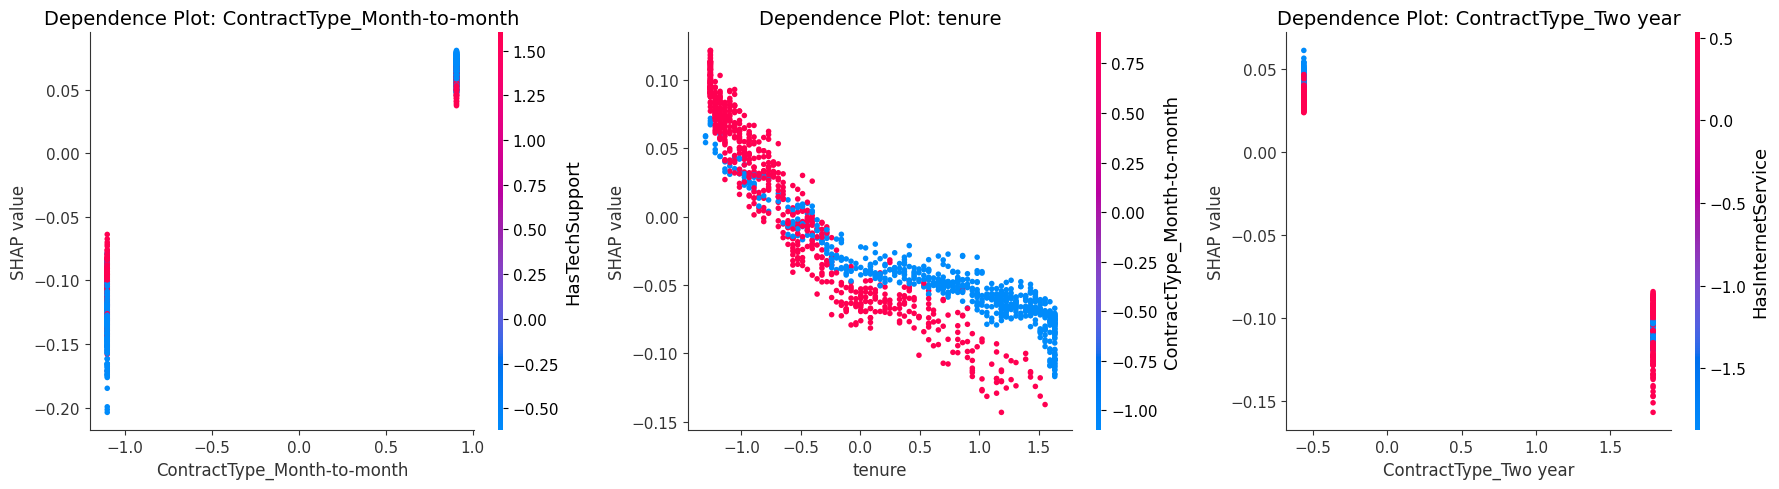

In [94]:
plt.style.use('default')
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, feature in enumerate(top_features):
    shap.dependence_plot(
        feature, 
        shap_values[:, :, 1], 
        X_test_processed_df, 
        display_features=X_test_processed_df,
        ax=axes[i],
        show=False
    )
    axes[i].set_title(f'Dependence Plot: {feature}', fontsize=14)
    axes[i].set_xlabel(feature, fontsize=12)
    axes[i].set_ylabel('SHAP value', fontsize=12)

plt.tight_layout()
plt.show()